In [96]:
import sys, os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install --upgrade typing_extensions
# !pip install openai
from openai import OpenAI
from dotenv import load_dotenv
from pathlib import Path
from src.data.raw_data_inspection import inspect_raw_data
from src.data.create_dataset import split_and_save
from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import format_case_row, FewShotExample, build_fewshot_block, call_gpt_batch, stratified_sample_U
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors
from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import format_case_row, FewShotExample, build_fewshot_block, call_gpt_batch, stratified_sample_U
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors
from src.visualization.eda import plot_label_distribution, plot_continuous_hists_by_label, plot_violin_by_label, plot_categorical_counts_by_label, plot_corr_heatmap
from src.data.preprocess import build_preprocessor, split_X_y
from src.visualization.model_vis import plot_logreg_coeffs, plot_calibration, plot_confusion_matrix, plot_prob_distribution
from src.visualization.cp_vis import plot_cp_results, plot_cp_gpt_measured
from src.evaluation.bootstrap_baseline import bootstrap_baseline

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data" / "processed"


## Introduction

We examine the limitations of accuracy as a sole metric in medical AI by focusing on false negatives in glaucoma diagnosis. Using electronic health records, we train a logistic regression baseline that reaches strong overall performance (ACC ≈ 0.93, AUROC ≈ 0.98) yet still produces six false negatives. We then apply conformal prediction (CP) to separate confident from uncertain cases, which enables deferral of ambiguous predictions. Under oracle conditions, false negatives nearly disappear, while a GPT-based proxy for expert review provides a realistic lower bound that still reduces false negatives compared with the baseline. These results demonstrate that uncertainty-aware methods such as CP substantially improve the safety and reliability of medical AI beyond what accuracy alone conveys.

## Explorative Data Analysis

### Dataset metrics

In [45]:
RAW_CSV = PROJECT_ROOT / "data" / "raw" / "ds_whole.csv"
df = inspect_raw_data(RAW_CSV)

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RL                499 non-null    object 
 1   glaucoma          499 non-null    int64  
 2   age               499 non-null    int64  
 3   ocular_pressure   499 non-null    int64  
 4   MD                499 non-null    float64
 5   PSD               499 non-null    float64
 6   GHT               499 non-null    int64  
 7   cornea_thickness  499 non-null    int64  
 8   RNFL4.mean        499 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 35.2+ KB
None 

Missing Values Info
RL                  0
glaucoma            0
age                 0
ocular_pressure     0
MD                  0
PSD                 0
GHT                 0
cornea_thickness    0
RNFL4.mean          0
dtype: int64 

Basic Summary
         RL    glaucoma         age  ocular_pressure

1. The dataset has 499 samples, and it is fairly balanced, with about 60% positive cases and 40% negative cases. 

2. It has 9 features: age, ocular pressure, MD, PSD, GHT, cornea thickness, RNFL4.mean, RL, glaucoma. Please check this website for variable definition: https://www.kaggle.com/code/muhammadfaizan65/human-glaucoma-eda-gbc/input. 

3. The dataset has no missing values.

### Visualizations

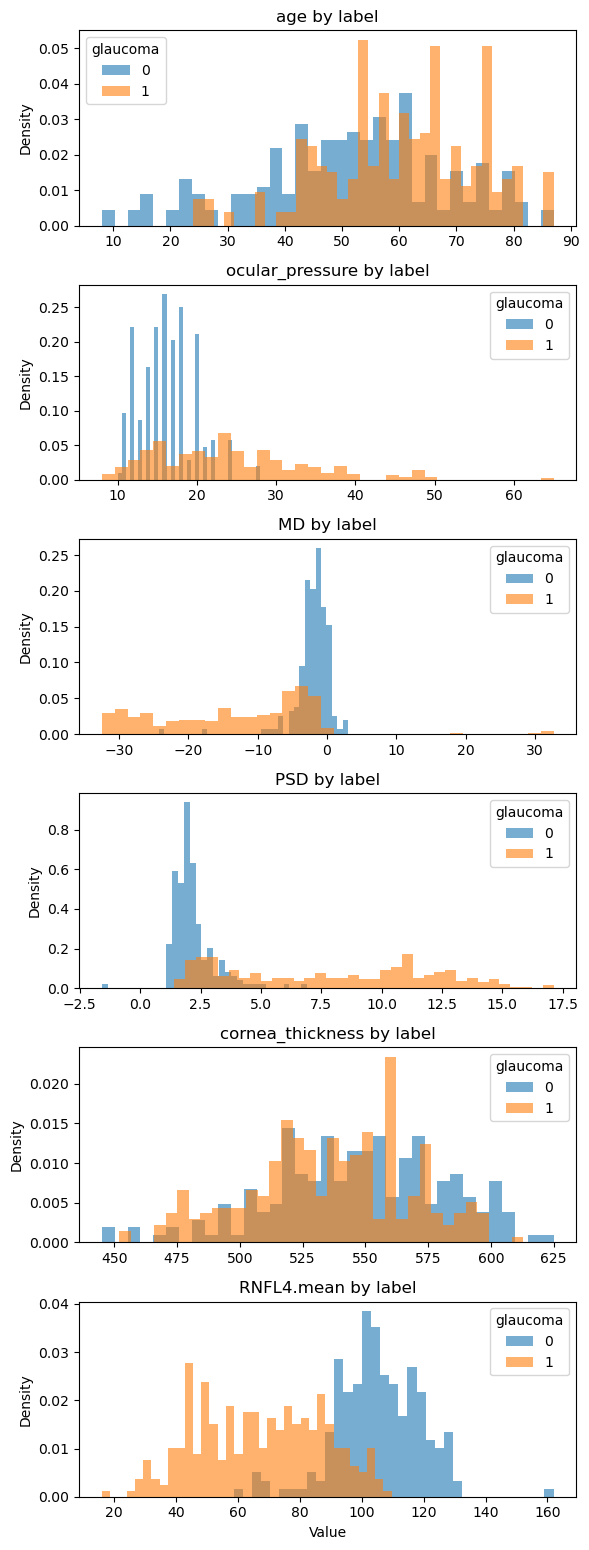

In [49]:
plot_continuous_hists_by_label(df, bins=35)

MD、PSD、RNFL are strongly discriminative features in this dataset. However, there still exists overlaps, where False Negative cases might happen.

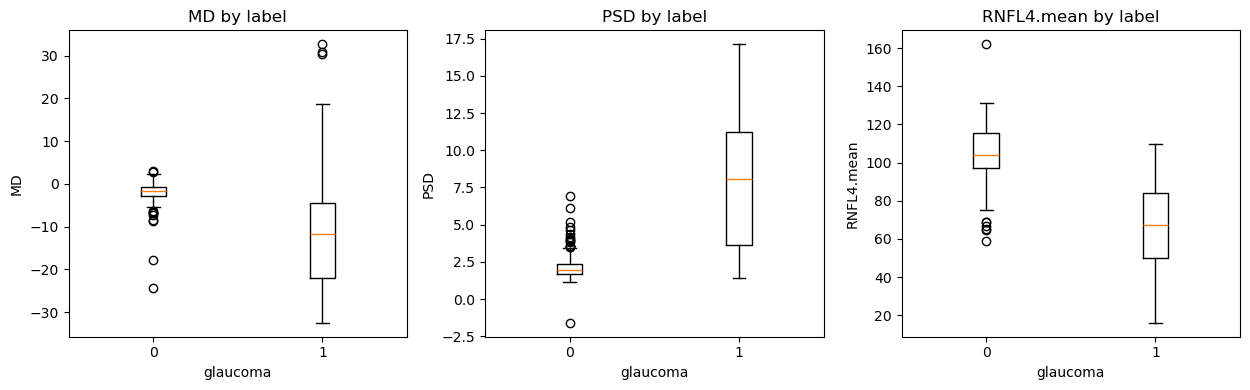

In [51]:
plot_violin_by_label(df, cols=("MD","PSD","RNFL4.mean"))

Taking a closer look on these variables, MD variable separates groups clearly, positive cases' PSD has higher variance with some overlapping regions, RNFL4.mean has significant difference with some overlapping.

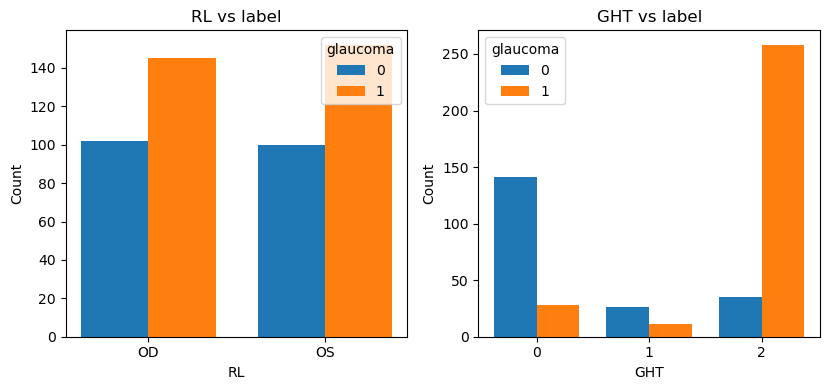

In [78]:
plot_categorical_counts_by_label(df, cols=["RL","GHT"])

1. RL has no clear difference between positive and negative cases.

2. Positive cases cluster around high value of GHT, negative cases at ower values.

3. Taken these information together, we can use few shot training to train an LLM to mimic medical expert on learning these three variables.

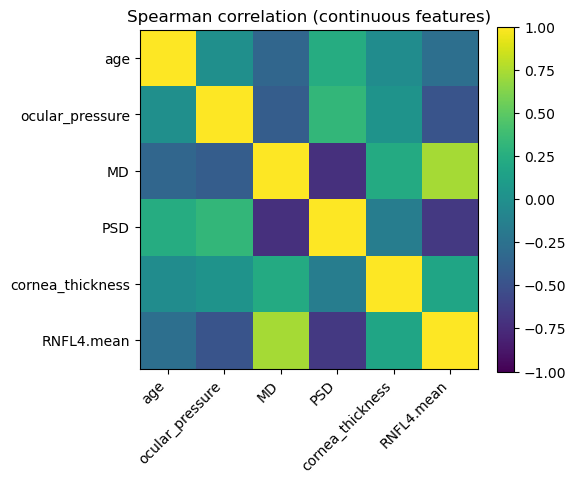

In [79]:
plot_corr_heatmap(df)

1. MD strongly positively correlated with RNFL4.mean.

2. PSD negatively correlated with MD.

3. Age, cornea thickness, and ocular pressure show weaker associations.

Some redundancy exists, such as MD and RNFL, which worsen model's capability to classify cases.

## Baseline Model

### Model Performance

In [57]:
split_and_save(test_size=0.2, calib_size=0.2, random_state=42)
train = pd.read_pickle(DATA_DIR / "train.pkl")
calib = pd.read_pickle(DATA_DIR / "calib.pkl")
test  = pd.read_pickle(DATA_DIR / "test.pkl")

pipe = train_logreg(train)

m_test, proba_test, yhat_test = evaluate(pipe, test, threshold=0.5)
FN_baseline = m_test["FN"]
print("Baseline metrics:", m_test)

Baseline metrics: {'ACC': 0.93, 'AUROC': 0.9842910293509715, 'TP': 53, 'FP': 1, 'TN': 40, 'FN': 6, 'RECALL': 0.8983050847457474, 'PRECISION': 0.9814814814814633, 'F1': 0.9380530973451244}


In [97]:
X_test, y_test_true = split_X_y(test)
proba_pos = proba_test[:, 1] if getattr(proba_test, "ndim", 1) == 2 else proba_test

# Run bootstrap
boot_df, boot_summary = bootstrap_baseline(
    y_true=y_test_true,
    proba_pos=proba_pos,
    n_boot=500,          # adjust as needed
    threshold=0.5,
    random_state=42
)

# Show compact summary for key metrics
display(boot_summary.loc[["FN","ACC","AUROC","RECALL","PRECISION","F1"]])

,mean,ci_low,ci_high
FN,6.094000,1.000000,11.000000
ACC,0.929300,0.874750,0.980000
AUROC,0.984130,0.964303,0.998083
RECALL,0.896404,0.814156,0.979592
PRECISION,0.981926,0.941176,1.000000
F1,0.936688,0.888889,0.980769


### Visualizations

In [60]:
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

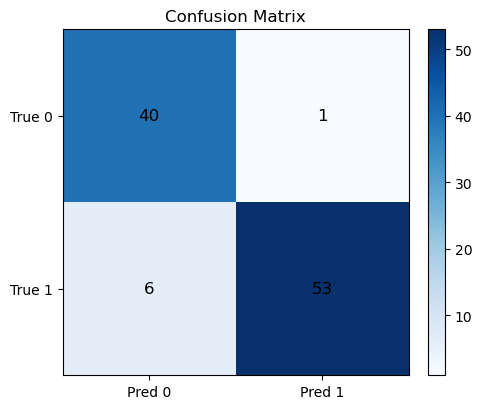

In [98]:
plot_confusion_matrix(test, yhat_test, save_path=FIG_DIR / "baseline_confusion.png")

1. The baseline logistic regression achieves strong overall performance (93% accuracy), but still produces 6 false negatives.

2. In a medical context, false negatives are the most dangerous type of error, since glaucoma patients would be told they are healthy.

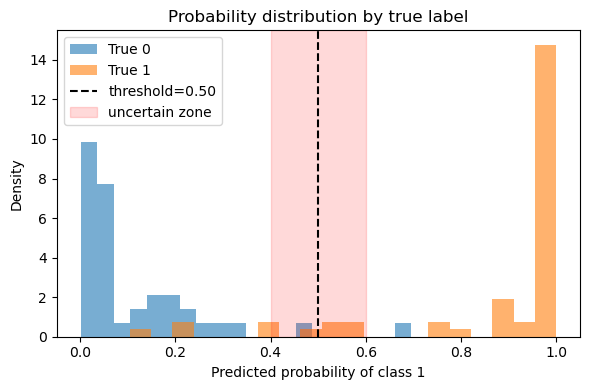

In [99]:
plot_prob_distribution(test, proba_test, save_path=FIG_DIR / "baseline_probdist.png")

1. Most predictions by the baseline model are correct, showing good separability.

2. However, in the zone highlighted by red, both classes overlap. These places are where the model is unsure, but still forced to make a hard decision ausing FN to happen.

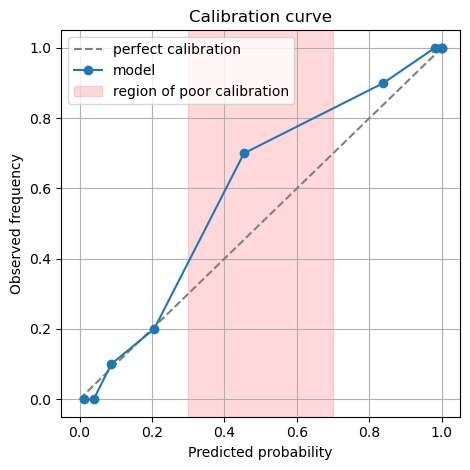

In [100]:
X_test, y_test_true = split_X_y(test)
plot_calibration(pipe, X_test, y_test_true, save_path=FIG_DIR / "baseline_calibration.png")

1. The model has fair calibration, but in the red highlighted region the curve deviates from the perfect calibration. This means predicted probabilities in this region don’t match the true likelihood of disease.

2. Clinicans cannot trust the model’s stated probabilities in this mid-range.

## Conformal Prediction Classification Model

### Model Performance

In [31]:
alphas = [0.05, 0.10, 0.15, 0.20, 0.30]
records = []

for a in alphas:
    q = calibrate_threshold(pipe, calib, alpha=a)
    out = cp_partition(pipe, test, q)
    cnts = summarize_counts(out["y_true"], out["y_pred"], out["region"])
    cnts["alpha"] = a
    cnts["q"] = q
    cnts["FN_baseline"] = FN_baseline
    records.append(cnts)

df_cp = pd.DataFrame(records)
df_cp

,TP_confident,FN_confident,FP_confident,TN_confident,U_pos,U_neg,C_size,U_size,alpha,q,FN_baseline
0,53,6,1,40,0,0,100,0,0.05,0.685680,6
1,53,6,1,40,0,0,100,0,0.10,0.528078,6
2,49,3,1,39,7,1,92,8,0.15,0.393180,6
3,47,1,0,34,11,7,82,18,0.20,0.209705,6
4,45,1,0,26,13,15,72,28,0.30,0.109941,6


### Reasonable Approximation of Performance Upper Bound

In [32]:
def new_errors(FN_confident, FP_confident, U_pos, U_neg, s, t):
    FN_new = FN_confident + (1 - s) * U_pos
    FP_new = FP_confident + (1 - t) * U_neg
    return FN_new, FP_new

df_cp["FN_oracle"], df_cp["FP_oracle"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=1.0, t=1.0), axis=1))

s_gpt, t_gpt = 0.9, 0.85
df_cp["FN_gpt"], df_cp["FP_gpt"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=s_gpt, t=t_gpt), axis=1))

Saved figure to: /Users/jasondai/Desktop/uncertainty-aware-medAI/reports/figures/cp_fn_coverage.png


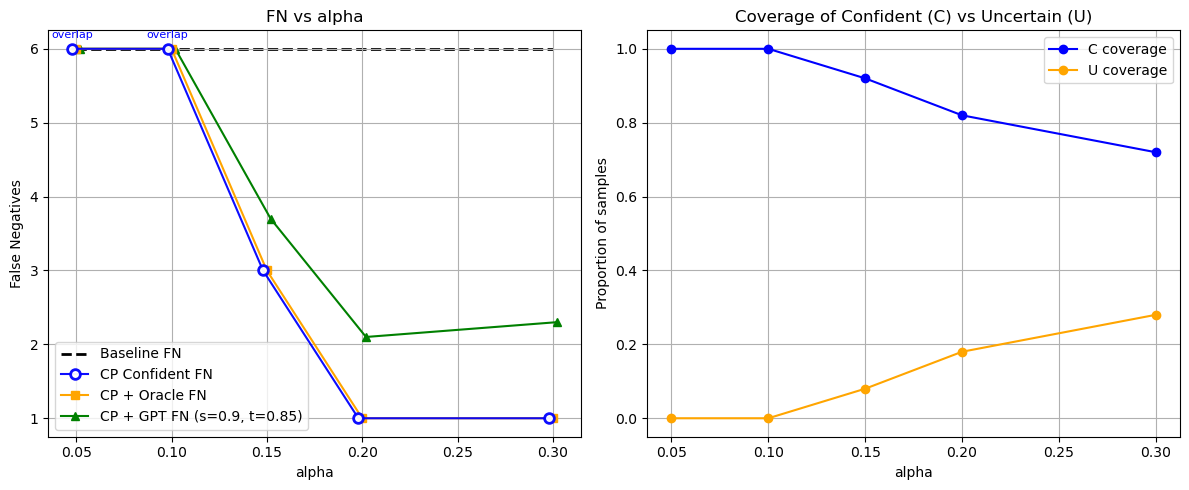

In [94]:
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def new_errors(FN_confident, FP_confident, U_pos, U_neg, s, t):
    FN_new = FN_confident + (1 - s) * U_pos
    FP_new = FP_confident + (1 - t) * U_neg
    return FN_new, FP_new

df_cp["FN_oracle"], df_cp["FP_oracle"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=1.0, t=1.0), axis=1))

s_gpt, t_gpt = 0.9, 0.85
df_cp["FN_gpt"], df_cp["FP_gpt"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=s_gpt, t=t_gpt), axis=1))
    
plot_cp_results(df_cp, total_size=len(test), s_gpt=0.9, t_gpt=0.85,
                save_path=FIG_DIR / "cp_fn_coverage.png")

Left Graph:

1. The black dashed line shows the baseline FN = 6: if we trust the model entirely, six glaucoma patients are missed.

2. Blue curve (“CP Confident FN”) shows that within the confident region, FN drop slightly as α increases, but the model is still making some misses.

3. Orange curve (“CP + Oracle FN”) shows the theoretical upper bound: if experts could always classify uncertain cases perfectly, FN would approach 1 at α=0.2 and above.

4. Green curve (“CP + GPT FN”) sits between baseline and oracle. With sensitivity ≈0.9 and specificity ≈0.85, GPT eliminates about half of the misses, but not all.

Right Graph:

1. Blue line: proportion of cases in the confident region decreases as α increases.

2. Orange line: uncertain cases grow with α, as higher α makes more samples flagged as uncertain. This trades off coverage for lower FN when experts step in. I think this reflect the cost of safety.

### Reasonable Approximation of Performance Upper Bound

In [34]:
%load_ext autoreload
%autoreload 2

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
sys.path.append(str(PROJECT_ROOT))


DATA_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR  = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
out = cp_partition(pipe, test, q)
test_u = test[out["region"] == "U"].copy()
print("Test-U size:", len(test_u), "\nLabel counts:\n", test_u["glaucoma"].value_counts())

out_calib = cp_partition(pipe, calib, q)
calib_u = calib[out_calib["region"] == "U"].copy()
dev_u, _ = stratified_sample_U(calib_u, n_per_class=4, seed=42)

fewshots = []
for _, row in dev_u.iterrows():
    case_card = format_case_row(row)
    fewshots.append(FewShotExample(case_card=case_card, label=int(row["glaucoma"])))
fewshot_block = build_fewshot_block(fewshots)
print(f"Few-shot examples: {len(fewshots)}")

Test-U size: 28 
Label counts:
 glaucoma
0    15
1    13
Name: count, dtype: int64
Few-shot examples: 8


In [37]:
def gpt_multiple_runs(client, model_name, test_u, fewshot_block, n_runs=5, temperature=0.3):
    case_cards = [format_case_row(r) for _, r in test_u.iterrows()]
    all_preds = []
    for r in trange(n_runs, desc="GPT runs"):
        gpt_out = call_gpt_batch(client, model=model_name, cases=case_cards,
                                 fewshot_block=fewshot_block, temperature=temperature)
        preds = []
        for item in gpt_out:
            try:
                preds.append(int(item["prediction"]))
            except:
                preds.append(None)
        all_preds.append(preds)
    return np.array(all_preds)

def evaluate_gpt_runs(all_preds, y_true):
    y_true = np.asarray(y_true).astype(int)
    mask_valid = ~np.any(all_preds==None, axis=0)
    y_true_eval = y_true[mask_valid]
    preds_eval = all_preds[:, mask_valid].astype(int)

    s_list, t_list = [], []
    for run in preds_eval:
        cm = confusion_from_preds(y_true_eval, run)
        s, t = sensitivity_specificity(cm)
        s_list.append(s); t_list.append(t)
    return np.array(s_list), np.array(t_list), y_true_eval, preds_eval


def bootstrap_ci(preds_eval, y_true_eval, n_boot=1000, alpha=0.05):
    rng = np.random.default_rng(42)
    n = len(y_true_eval)
    s_boot, t_boot = [], []
    for _ in range(n_boot):
        idx = rng.choice(n, size=n, replace=True)
        y_b = y_true_eval[idx]
        pred_b = (preds_eval[:, idx].mean(axis=0) >= 0.5).astype(int)
        cm = confusion_from_preds(y_b, pred_b)
        s, t = sensitivity_specificity(cm)
        s_boot.append(s); t_boot.append(t)
    low, high = alpha/2, 1-alpha/2
    s_ci = (np.nanpercentile(s_boot, low*100), np.nanpercentile(s_boot, high*100))
    t_ci = (np.nanpercentile(t_boot, low*100), np.nanpercentile(t_boot, high*100))
    return s_ci, t_ci

In [38]:
all_preds = gpt_multiple_runs(client, "gpt-4o-mini", test_u, fewshot_block, n_runs=5, temperature=0.2)

s_list, t_list, y_true_eval, preds_eval = evaluate_gpt_runs(all_preds, test_u["glaucoma"].values)
print("Run-wise sensitivity:", s_list)
print("Run-wise specificity:", t_list)
print("Mean s:", s_list.mean(), "±", s_list.std())
print("Mean t:", t_list.mean(), "±", t_list.std())

s_ci, t_ci = bootstrap_ci(preds_eval, y_true_eval, n_boot=1000)
print(f"Sensitivity 95% CI: {s_ci}")
print(f"Specificity 95% CI: {t_ci}")

s_mean, t_mean = s_list.mean(), t_list.mean()
df_cp["FN_gpt_meas"], df_cp["FP_gpt_meas"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg,
                         s=s_mean, t=t_mean), axis=1
))

GPT runs: 100%|██████████| 5/5 [02:57<00:00, 35.45s/it]

Run-wise sensitivity: [0.76923077 0.76923077 0.76923077 0.76923077 0.76923077]
Run-wise specificity: [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
Mean s: 0.7692307692307693 ± 0.0
Mean t: 0.6666666666666666 ± 0.0
Sensitivity 95% CI: (0.533235294117647, 1.0)
Specificity 95% CI: (0.4, 0.9090909090909091)


Saved figure to: /Users/jasondai/Desktop/uncertainty-aware-medAI/reports/figures/cp_fn_gpt_measured_bootstrap.png


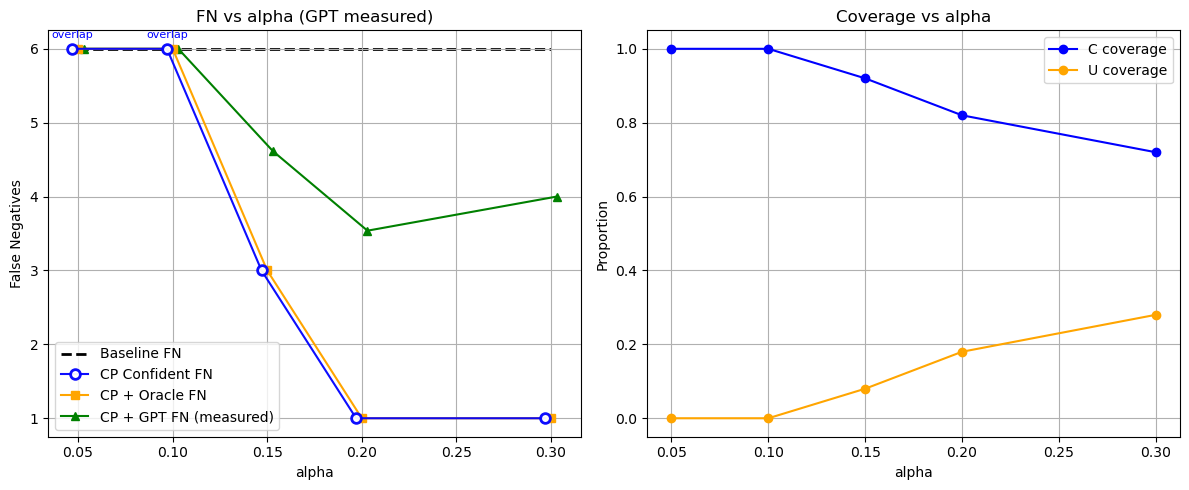

In [95]:
plot_cp_gpt_measured(df_cp, total_size=len(test), save_path=FIG_DIR / "cp_fn_gpt_measured_bootstrap.png")

Left Graph:

1. Green curve is now based on GPT’s empirically measured sensitivity (~0.77) and specificity (~0.67) on uncertain cases.

2. FN are reduced from baseline, but not as aggressively as in the first figure: they plateau around 3–4 misses instead of 1.

3. This highlights the practical lower bound: actual LLM “experts” won’t perfectly handle uncertain cases, but they still reduce FN significantly.

Right Graph:

1. Blue line: proportion of cases in the confident region decreases as α increases.

2. Orange line: uncertain cases grow with α, as higher α makes more samples flagged as uncertain. This trades off coverage for lower FN when experts step in. I think this reflect the cost of safety. 